In [1]:
import cobra
import libsbml
from cobra.core import Metabolite, Reaction
import pandas as pd
df = pd.read_excel("ProcessedData_v2.xlsx")
from cobra import flux_analysis
ModelF = cobra.io.read_sbml_model("CAM_12PModel_v2_Stijn.xml")
ModelF.solver="glpk"
cobra.flux_analysis.pfba(ModelF)

PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c7")
print(PEPC_rxn.flux)
print("-------")
phloem_rxn = ModelF.reactions.get_by_id("Diel_phloem_export")      #Phloem export represents output of the model (=sucrose + amino acids)    
print(phloem_rxn.flux)
print("-------")

#adding maintenance cost
PPFD = 100                            #light intensity of the model
ATPase = (0.0049*PPFD) + 2.7851       #non-growth assocaited maintenance (NGAM) cost based on light - see Topfer et al 2020 Supplemental information section 1.2.3
for i in range(1,13):
    ModelF.reactions.get_by_id("ATPase_tx"+str(i)).lower_bound = ATPase
    ModelF.reactions.get_by_id("ATPase_tx"+str(i)).upper_bound = ATPase
    
    #Setting NADPH demand to 1/3 of ATP demand and distributing this demand to cytosol, plastid and mitochondria based on Cheung et al 2013 (doi: 10.1111/tpj.12252)
    ModelF.reactions.get_by_id("NADPHoxc_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxc_tx"+str(i)).upper_bound = ATPase/9
    
    ModelF.reactions.get_by_id("NADPHoxp_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxp_tx"+str(i)).upper_bound = ATPase/9
    
    ModelF.reactions.get_by_id("NADPHoxm_tx"+str(i)).lower_bound = ATPase/9
    ModelF.reactions.get_by_id("NADPHoxm_tx"+str(i)).upper_bound = ATPase/9
    
met = ModelF.metabolites.PROTON_e1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
cobra.flux_analysis.pfba(ModelF)

PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c7")
print(PEPC_rxn.flux)
print("-------")
phloem_rxn = ModelF.reactions.get_by_id("Diel_phloem_export")
print(phloem_rxn.flux)
#ModelF.metabolites.PROTON_c6.summary()
#ModelF.metabolites.PROTON_m6.summary()
#ModelF.metabolites.PROTON_p1.summary()

4.450782702947559
-------
0.42999264936692144
-------
PROTON_ATPase_c1	0.3105325415071109
0.65 ATP_c1 + 0.45 PROTON_c1 + WATER_c1 + 0.35 aATP_c1 --> 0.5 ADP_c1 + PROTON_e1 + 0.7 Pi_c1 + 0.5 aADP_c1 + 0.3 aPi_c1
-------
Phloem_output_tx1	-0.3097224281318271
0.0022970297 4_AMINO_BUTYRATE_c1 + 0.0004186704 ARG_c1 + 0.0015049505 ASN_c1 + 0.0004186704 CYS_c1 + 0.0792079208 FRU_c1 + 0.0693069307 GLC_c1 + 0.0240792079 GLN_c1 + 0.0124356436 GLT_c1 + 0.0007128713 GLY_c1 + 0.0004186704 HIS_c1 + 0.0017425743 ILE_c1 + 0.0020594059 LEU_c1 + 0.0022178218 LYS_c1 + 0.0038811881 L_ALPHA_ALANINE_c1 + 0.006019802 L_ASPARTATE_c1 + 0.0004186704 MET_c1 + 0.0057029703 PHE_c1 + 0.9603960396 PROTON_e1 + 0.0004186704 PRO_c1 + 0.003960396 SER_c1 + 0.0068910891 THR_c1 + 0.0004186704 TRP_c1 + 0.0004186704 TYR_c1 + 0.0027722772 VAL_c1 + 0.7326732673 sSUCROSE_b1 --> 0.9603960396 PROTON_c1 + Phloem_e1
-------
5.8315578352997575
-------
0.35750555178863164


In [2]:
ModelF3 = ModelF.copy()

In [3]:
#Constraint stuff
#Constrain ATP_ADP_Pi_pc to 0 (we know NTT, plastidic nucleotide transporter is only active in importing ATP to chloroplast at night or in non-photosynthetic tissues (Reinhold et al., 2007; Flugge et al., 2011; Voon and Lim, 2019))

for i in range(1,7):    
    ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc"+str(i)).upper_bound = 0
    
#Constrain PEPCK to 0 and replace it by ME (because we are modelling Phalaenopsis)    
    
for i in range(1,13):    
    ModelF3.reactions.get_by_id("PEPCARBOXYKIN_RXN_c"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("PEPCARBOXYKIN_RXN_c"+str(i)).upper_bound = 0

#Remove reaction H_pc (because this was included as a hypothetical reaction)

for i in range(1,13):    
    ModelF3.reactions.get_by_id("H_pc"+str(i)).lower_bound = 0
    ModelF3.reactions.get_by_id("H_pc"+str(i)).upper_bound = 0
    
#Remove reaction H_mc (because this was included as a hypothetical reaction)

# for i in range(1,13):    
#     ModelF3.reactions.get_by_id("H_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("H_mc"+str(i)).upper_bound = 0

#Change direction of PYR-H symporter allowing only PYR import into mitonchondria (Le et al., 2022)

for i in range(1,13):    
    ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i)).lower_bound = -1000
    ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i)).upper_bound = 0
    
#Constrain NADP-dependent malic enzyme (both cytosolic and plastidic) since NAD-ME (mitochondrial) is the major decarboxylating enzyme in Phalaenopsis/Kalanchoë

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).upper_bound = 0

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).upper_bound = 0
    
#Constrain plastidic PPDK 

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).upper_bound = 0

#Constrain a flux ratio between NADP-ME and NAD-ME according to Dever et al. 2015 and own measurements in Kalanchoë
for i in range(1,13):
    new_constraint1 = ModelF3.problem.Constraint(
        8*(ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i)).flux_expression + ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i)).flux_expression) - ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i)).flux_expression,
        lb=0,
        ub=0)
    ModelF3.add_cons_vars(new_constraint1)
    
#Constrain a flux ratio between PPDK_c and PPDK_p according to Kondo et al. 2000 and Dever et al. 2015
for i in range(1,13):
    new_constraint2 = ModelF3.problem.Constraint(
        2*ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux_expression - ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c"+str(i)).flux_expression,
        lb=0,
        ub=0)
    ModelF3.add_cons_vars(new_constraint2)

#Checking different mitochondrial malate importers

# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_Pi_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_Pi_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("OAA_MAL_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("OAA_MAL_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_SUC_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_SUC_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("FUMHYDR_RXN_m"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("FUMHYDR_RXN_m"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_SO4_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_SO4_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_CIT_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_CIT_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("2KG_MAL_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("2KG_MAL_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_ISOCITRATE_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_ISOCITRATE_mc"+str(i)).upper_bound = 0
    
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("MAL_ACONITATE_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("MAL_ACONITATE_mc"+str(i)).upper_bound = 0

# Check importance of PiC transporter 
# for i in range(1,13):
#     ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i)).upper_bound = 0

#Constrain different Rubisco carboxylase and oxygenase ratios (Vc/Vo)
#Vc/Vo = 2
# for i in range(1,7):
#     new_constraint3 = ModelF3.problem.Constraint(
#         2*ModelF3.reactions.get_by_id("RXN_961_p"+str(i)).flux_expression - ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i)).flux_expression,
#         lb=0,
#         ub=0)
#     ModelF3.add_cons_vars(new_constraint3)

#Check importance of mATPsynthase 
# for i in range(1,7):
#     ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i)).lower_bound = 0
#     ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i)).upper_bound = 0


In [4]:
#PYR-H symport reaction
# for i in range(1,13):
#     rxn = Reaction("PYR_H_mc"+str(i)+"_symport",name = "PYR_H_mc"+str(i)+"_symport")
   
#     rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PROTON_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PROTON_c"+str(i)):1})
   
#     rxn.lower_bound = 0
#     rxn.upper_bound = 1000
#     ModelF3.add_reaction(rxn)

In [5]:
# PYR-H antiport reaction
# for i in range(1,13):
#     rxn = Reaction("PYR_H_mc"+str(i)+"_antiport",name = "PYR_H_mc"+str(i)+"_antiport")
   
#     rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
#                          ModelF3.metabolites.get_by_id("PROTON_m"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1,
#                          ModelF3.metabolites.get_by_id("PROTON_c"+str(i)):-1})
   
#     rxn.lower_bound = 0
#     rxn.upper_bound = 1000
#     ModelF3.add_reaction(rxn)

In [6]:
# #PYR channel reaction
for i in range(1,13):
    rxn = Reaction("PYR_mc"+str(i)+"_channel",name = "PYR_mc"+str(i)+"_channel")
   
    rxn.add_metabolites({ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i)):-1,
                         ModelF3.metabolites.get_by_id("PYRUVATE_c"+str(i)):1})
   
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    ModelF3.add_reaction(rxn)

In [7]:
#Avoid mitochondrial pyruvate pools are being mixed
# from cobra.core import Metabolite
# for i in range(1,7):
#     metA=Metabolite("A"+str(i))

#     metPyr=ModelF3.metabolites.get_by_id("PYRUVATE_m"+str(i))

#     ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i)).add_metabolites({metA:-1, metPyr:+1})

#     ModelF3.reactions.get_by_id("PYRUVDEH_RXN_m"+str(i)).add_metabolites({metA:-1, metPyr:+1})

In [8]:
sol3 = flux_analysis.parsimonious.pfba(ModelF3)

In [9]:
for rxn in ModelF3.reactions.query("H_tx"):
    print(rxn.id+"\t"+str(rxn.flux))

H_tx1	0.0
H_tx2	0.0
H_tx3	0.0
H_tx4	0.0
H_tx5	0.0
H_tx6	0.0
H_tx7	0.2648098721492464
H_tx8	0.0
H_tx9	0.0
H_tx10	0.0
H_tx11	0.0
H_tx12	0.0


In [10]:
for rxn in ModelF3.reactions.query("HYPO"):
    print(rxn.id+"\t"+str(rxn.flux))

unlProtHYPO_c1	0.0
unlProtHYPO_c2	0.0
unlProtHYPO_c3	0.0
unlProtHYPO_c4	0.0
unlProtHYPO_c5	0.0
unlProtHYPO_c6	0.0
unlProtHYPO_c7	0.0
unlProtHYPO_c8	0.0
unlProtHYPO_c9	0.0
unlProtHYPO_c10	0.0
unlProtHYPO_c11	0.0
unlProtHYPO_c12	0.0


In [11]:
for rxn in ModelF3.reactions.query("_accumulation"):
    if "PROTON_v" in rxn.id:
        print(rxn.id+"\t"+str(rxn.flux))

PROTON_v1_accumulation	34.17270974202508
PROTON_v2_accumulation	19.705958759341865
PROTON_v3_accumulation	5.180224351419795
PROTON_v4_accumulation	2.0427618865735475
PROTON_v5_accumulation	0.863204448735499
PROTON_v6_accumulation	0.0
PROTON_v7_accumulation	9.079867881067573
PROTON_v8_accumulation	10.961512324778951
PROTON_v9_accumulation	19.399554060914575
PROTON_v10_accumulation	28.607514294099644
PROTON_v11_accumulation	37.89968752931021
PROTON_v12_accumulation	47.400596718370224


In [12]:
phloem_rxn = ModelF3.reactions.get_by_id("Diel_phloem_export")
print(phloem_rxn.flux)

0.35688798161219826


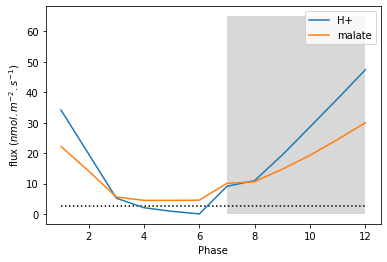

In [13]:
xlist = list()
ylist1 = list()
ylist2 = list()
ylist3 = list()
for i in range(1,13):
    i1 = i
    if i != 12:
        i2 = i+1
    else:
        i2 = 1
    xlist.append(i)
    ylist1.append(sol3["PROTON_v"+str(i)+"_accumulation"])
    ylist2.append(sol3["MAL_v"+str(i)+"_accumulation"]+sol3["aMAL_v"+str(i)+"_accumulation"])
    ylist3.append(ylist1[i-1]/ylist2[i-1])
    

import matplotlib.pyplot as plt

plt.plot(xlist,ylist1,label="H+")
plt.plot(xlist,ylist2,label="malate")
plt.hlines(2.5,1,12,linestyles="dotted")
plt.fill_between(xlist[6:],65,facecolor='grey',alpha=0.3)
plt.legend()
plt.xlabel("Phase")
plt.ylabel("flux ("+r'$ nmol.m^{-2}.s^{-1}$'+")")
plt.show()

In [14]:
i = 6
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))

In [15]:
#CBB
cbb_H = 0
rxn = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("PHOSGLYPHOS_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
# print(cbb_H)
rxn = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
cbb_H = cbb_H+(rxn.flux*rxn.metabolites[met])
cbb_H

5.740330100300404

In [16]:
#for starch
starch_H = 0
rxn = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
starch_H = starch_H+(rxn.flux*rxn.metabolites[met])
# print(starch_H)
rxn = ModelF3.reactions.get_by_id("GLUC1PADENYLTRANS_RXN_p"+str(i))
starch_H = starch_H+(rxn.flux*rxn.metabolites[met])
# print(starch_H)
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
starch_H = starch_H+((rxn.flux*rxn.metabolites[met])*(1-(ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux/rxn.flux)))
starch_H

0.085724848622818

In [17]:
#PK --> I looked only to PPDK (PYR --> PEP)
pk_H = 0
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
pk_H = pk_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
pk_H = pk_H+((rxn.flux*rxn.metabolites[met])*ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i)).flux/rxn.flux)
rxn = ModelF3.reactions.get_by_id("ADENYL_KIN_RXN_p"+str(i))
pk_H = pk_H+(rxn.flux*rxn.metabolites[met])
pk_H

0.5761371726126716

In [18]:
#sucrose synthesis
SS_H = 0
met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
rxn = ModelF3.reactions.get_by_id("UDPKIN_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_SYNTHASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("GLUC1PURIDYLTRANS_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_PHOSPHATASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("SUCROSE_PHOSPHATE_SYNTHASE_RXN_c"+str(i))
SS_H = SS_H+(rxn.flux*rxn.metabolites[met])
SS_H

-0.06023670379774404

In [19]:
#sucrose synthesis
GNG_H = 0
rxn = ModelF3.reactions.get_by_id("PHOSGLYPHOS_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("F16BDEPHOS_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
rxn = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
GNG_H = GNG_H+(rxn.flux*rxn.metabolites[met])
GNG_H

-0.5340859060183656

In [20]:
#check activity of TCA cycle 
met = ModelF3.metabolites.CIT_m2

for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

In [50]:
#general worksheet for figures
  
met = ModelF3.metabolites.PYRUVATE_p2

for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

# met = ModelF3.metabolites.MAL_v12
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")

# met = ModelF3.metabolites.PYRUVATE_m2
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")
        
# met = ModelF3.metabolites.ATP_c2
# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")


PYRUVATE_pc2	0.42067631285405616
PYRUVATE_p2 <=> PYRUVATE_c2
-0.42067631285405616
-------
ACETOLACTSYN_RXN_p2	-0.00258655444402314
PROTON_p2 + 2.0 PYRUVATE_p2 --> 2_ACETO_LACTATE_p2 + CARBON_DIOXIDE_p2
0.00129327722201157
-------
DIHYDRODIPICSYN_RXN_p2	-0.0005936354593331461
L_ASPARTATE_SEMIALDEHYDE_p2 + PYRUVATE_p2 --> 2_3_DIHYDRODIPICOLINATE_p2 + PROTON_p2 + 2.0 WATER_p2
0.0005936354593331461
-------
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p2	-0.41681465364745707
0.9 ATP_p2 + PYRUVATE_p2 + Pi_p2 + 0.1 aATP_p2 --> AMP_p2 + PHOSPHO_ENOL_PYRUVATE_p2 + 0.55 PPI_p2 + 1.55 PROTON_p2 + 0.45 bPPI_p2
0.41681465364745707
-------


In [22]:
#Oxidative phosphorylation calculations

daytimeMitProducing = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_m"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            daytimeMitProducing += rxn.flux*rxn.metabolites[met]
print("Total proton flux produced in the mitochondria during daytime:" +str(daytimeMitProducing))


ATPmito1 = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_m"+str(i))
    rxn = ModelF3.reactions.get_by_id("1_PERIOD_10_PERIOD_2_PERIOD_2_RXN_mi"+str(i))
    ATPmito1 += rxn.flux*rxn.metabolites[met]
    
ATPmito2 = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_m"+str(i))
    rxn = ModelF3.reactions.get_by_id("CYTOCHROME_C_OXIDASE_RXN_mi"+str(i))
    ATPmito2 += rxn.flux*rxn.metabolites[met]

ATPmito3 = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_m"+str(i))
    rxn = ModelF3.reactions.get_by_id("NADH_DEHYDROG_A_RXN_mi"+str(i))
    ATPmito3 += rxn.flux*rxn.metabolites[met]

ETC=ATPmito1+ATPmito2+ATPmito3
print("Total daytime proton flux consumed by the mitochondrial ETC:" +str(ETC))

ATPsynt = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_m"+str(i))
    rxn = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
    ATPsynt += rxn.flux*rxn.metabolites[met]
print("Total daytime proton flux through ATP synthase:" +str(ATPsynt))

Total proton flux produced in the mitochondria during daytime:276.3446236480545
Total daytime proton flux consumed by the mitochondrial ETC:-266.5579296607856
Total daytime proton flux through ATP synthase:177.56574698180827


In [23]:
#summarizing top 5 proton producing/consuming reactions during daytime and nighttime relative to the cytosol
#Daytime
fout = open("DaytimeProducing.csv","w")
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            fout.write(rxn.id+","+str(((rxn.flux*rxn.metabolites[met])*60*60*2)/1000)+"\n") #convert per sec to per 2h (60*60*2) --> mmol/m-2/s-1
                        
fout.close()

df = pd.read_csv('DaytimeProducing.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'DaytimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df.to_csv('DaytimeProducing.csv', index=False)
dff = df.groupby(['RxnID']).DaytimeFlux.sum().reset_index()
dff.sort_values("DaytimeFlux", axis=0, ascending=False, inplace=True, na_position='first') 
dff.to_csv('DaytimeProducing.csv', index=True)


fout = open("DaytimeConsuming.csv","w")
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            fout.write(rxn.id+","+str(((rxn.flux*rxn.metabolites[met])*60*60*2)/1000)+"\n") 
                        
fout.close()

df = pd.read_csv('DaytimeConsuming.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'DaytimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df.to_csv('DaytimeConsuming.csv', index=False)
dff = df.groupby(['RxnID']).DaytimeFlux.sum().reset_index()
dff.sort_values("DaytimeFlux", axis=0, ascending=True, inplace=True, na_position='first') 
dff.to_csv('DaytimeConsuming.csv', index=True)

#Nighttime
fout = open("NighttimeProducing.csv","w")
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            fout.write(rxn.id+","+str(((rxn.flux*rxn.metabolites[met])*60*60*2)/1000)+"\n")
                        
fout.close()

df = pd.read_csv('NighttimeProducing.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'NighttimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df['RxnID'] = df['RxnID'].map(lambda x: x.rstrip('1'))
df.to_csv('NighttimeProducing.csv', index=False)
dff = df.groupby(['RxnID']).NighttimeFlux.sum().reset_index()
dff.sort_values("NighttimeFlux", axis=0, ascending=False, inplace=True, na_position='first') 
dff.to_csv('NighttimeProducing.csv', index=True)

fout = open("NighttimeConsuming.csv","w")
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            fout.write(rxn.id+","+str(((rxn.flux*rxn.metabolites[met])*60*60*2)/1000)+"\n")
                        
fout.close()

df = pd.read_csv('NighttimeConsuming.csv', header=None)
df.rename(columns={0: 'RxnID', 1: 'NighttimeFlux'}, inplace=True)
df['RxnID'] = df['RxnID'].map(lambda x: str(x)[:-1])
df['RxnID'] = df['RxnID'].map(lambda x: x.rstrip('1'))
df.to_csv('NighttimeConsuming.csv', index=False)
dff = df.groupby(['RxnID']).NighttimeFlux.sum().reset_index()
dff.sort_values("NighttimeFlux", axis=0, ascending=True, inplace=True, na_position='first') 
dff.to_csv('NighttimeConsuming.csv', index=True)

In [24]:
#Total daytime proton producing flux
daytimeProducing = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            daytimeProducing += ((rxn.flux*rxn.metabolites[met])*60*60*2)/1000 #convert units
print("Total proton flux produced during daytime:" +str(daytimeProducing))
                        
#Total daytime proton consuming flux
daytimeConsuming = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            daytimeConsuming += ((rxn.flux*rxn.metabolites[met])*60*60*2)/1000
print("Total proton flux consumed during daytime:" +str(daytimeConsuming))

#Total nighttime proton producing flux
nighttimeProducing = 0
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            nighttimeProducing += ((rxn.flux*rxn.metabolites[met])*60*60*2)/1000
print("Total proton flux produced during nighttime:" +str(nighttimeProducing))

#Total nighttime proton consuming flux
nighttimeConsuming = 0
for i in range(7,13):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]<0:
            nighttimeConsuming += ((rxn.flux*rxn.metabolites[met])*60*60*2)/1000
print("Total proton flux consumed during nighttime:" +str(nighttimeConsuming))

Total proton flux produced during daytime:790.3340509104781
Total proton flux consumed during daytime:-790.3596512566293
Total proton flux produced during nighttime:796.7300491416497
Total proton flux consumed during nighttime:-796.7393056549395


In [25]:
#Checking contribution of mitochondrial and plastidial ATP synthesis

ATPdayMito = 0
for i in range(1,7):
    rxn = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
    ATPdayMito += rxn.flux
print("Total daytime flux through ATP synthase in mitochondria:" +str(ATPdayMito))
                        
ATPdayPlast = 0
for i in range(1,7):
    rxn = ModelF3.reactions.get_by_id("Plastidial_ATP_Synthase_p"+str(i))
    ATPdayPlast += rxn.flux
print("Total daytime flux though ATP synthase in plastid:" +str(ATPdayPlast))

TotalATPday = ATPdayMito+ATPdayPlast 
RelContrMito = (ATPdayMito/TotalATPday)*100
RelContrPlast = 100-RelContrMito
print("Relative contribution of daytime mitochondrial ATP synthesis:" +str(RelContrMito)+"%")
print("Relative contribution of daytime plastidial ATP synthesis:" +str(RelContrPlast)+"%")

ATPdayProdMito = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("ATP_m"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            ATPdayProdMito += rxn.flux*rxn.metabolites[met]
print("Total daytime ATP produced in mitochondria:" +str(ATPdayProdMito))

ATPdayProdPlast = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("ATP_p"+str(i))
    for rxn in met.reactions:
        if round(rxn.flux,3)!=0 and rxn.flux*rxn.metabolites[met]>0:
            ATPdayProdPlast += rxn.flux*rxn.metabolites[met]
print("Total daytime ATP produced in plastid:" +str(ATPdayProdPlast))

Total daytime flux through ATP synthase in mitochondria:24.32407492901483
Total daytime flux though ATP synthase in plastid:39.33644447963377
Relative contribution of daytime mitochondrial ATP synthesis:38.20904251954671%
Relative contribution of daytime plastidial ATP synthesis:61.79095748045329%
Total daytime ATP produced in mitochondria:67.17674400392308
Total daytime ATP produced in plastid:106.21036393541016


In [26]:
#Fluxes through typical CAM reactions
starch = 0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
    #print(rxn.reaction)
    #print(rxn.flux)
    starch = starch+rxn.flux
print("---------------")
print("Total starch synthesized: "+str(starch))

MPC=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i))
    #print(rxn.reaction)
    #print(rxn.flux)
    MPC=MPC+rxn.flux
print("---------------")
print("Total flux through MPC: "+str(MPC))

# PYRsymport=0
# for i in range(1,13):
#     rxn = ModelF3.reactions.get_by_id("PYR_H_mc"+str(i)+"_symport")
# #     print(rxn.reaction)
# #     print(rxn.flux)
#     PYRsymport=PYRsymport+rxn.flux
# print("---------------")
# print("Total flux through PYRsymport: "+str(PYRsymport))

# PYRantiport=0
# for i in range(1,13):
#     rxn = ModelF3.reactions.get_by_id("PYR_H_mc"+str(i)+"_antiport")
#     #print(rxn.reaction)
#     #print(rxn.flux)
#     PYRantiport=PYRantiport+rxn.flux
# print("---------------")
# print("Total flux through PYRantiport: "+str(PYRantiport))

PYRchannel=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYR_mc"+str(i)+"_channel")
#     print(rxn.reaction)
#     print(rxn.flux)
    PYRchannel=PYRchannel+rxn.flux
print("---------------")
print("Total flux through PYRchannel: "+str(PYRchannel))

PEPC=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PEPCARBOX_RXN_c"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    PEPC=PEPC+rxn.flux
print("---------------")
print("Total flux through PEPC: "+str(PEPC))

NADME=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    NADME=NADME+rxn.flux
print("---------------")
print("Total flux through NADME: "+str(NADME))

NADPMEcyt=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    NADPMEcyt=NADPMEcyt+rxn.flux
print("---------------")
print("Total flux through NADPMEcyt: "+str(NADPMEcyt))

NADPMEplast=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    NADPMEplast=NADPMEplast+rxn.flux
print("---------------")
print("Total flux through NADPMEplast: "+str(NADPMEplast))

PPDKcyt=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    PPDKcyt=PPDKcyt+rxn.flux
print("---------------")
print("Total flux through PPDKcyt: "+str(PPDKcyt))

PPDKplast=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    PPDKplast=PPDKplast+rxn.flux
print("---------------")
print("Total flux through PPDKplast: "+str(PPDKplast))

RubOxy=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RXN_961_p"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    RubOxy=RubOxy+rxn.flux
print("---------------")
print("Total flux through RubOxy: "+str(RubOxy))

RubCarboxy=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    RubCarboxy=RubCarboxy+rxn.flux
print("---------------")
print("Total flux through RubCarboxy: "+str(RubCarboxy))

MalateEfflux=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("MAL_PROTON_rev_vc"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    MalateEfflux=MalateEfflux+rxn.flux
print("---------------")
print("Total flux through MalateEfflux: "+str(MalateEfflux))

PiC=0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    PiC=PiC+rxn.flux
print("---------------")
print("Total flux through PiC: "+str(PiC))

MalImp=0
for i in range (1,13):  
    rxn = ModelF3.reactions.get_by_id("MAL_PROTON_vc"+str(i))
#     print(rxn.reaction)
#     print(rxn.flux)
    MalImp=MalImp+rxn.flux
print("---------------")
print("Total malate imported in vacuole: "+str(MalImp))

ATPdayMito = 0
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
    ATPdayMito += rxn.flux
print("---------------")
print("Total flux through ATP synthase in mitochondria:" +str(ATPdayMito))

phloem_rxn = ModelF3.reactions.get_by_id("Diel_phloem_export")
print("---------------")
print("Diel phloem export flux: " +str(phloem_rxn.flux))

---------------
Total starch synthesized: 14.79078573904731
---------------
Total flux through MPC: -2.7845996000721183
---------------
Total flux through PYRchannel: 3.2958547522915384e-20
---------------
Total flux through PEPC: 27.20008121036684
---------------
Total flux through NADME: 0.0
---------------
Total flux through NADPMEcyt: 2.7451447674104688
---------------
Total flux through NADPMEplast: 0.0
---------------
Total flux through PPDKcyt: 0.4559309609365026
---------------
Total flux through PPDKplast: 2.7410949233862136
---------------
Total flux through RubOxy: 0.0
---------------
Total flux through RubCarboxy: 32.51465868369874
---------------
Total flux through MalateEfflux: 25.48960680594638
---------------
Total flux through PiC: -105.65569030867866
---------------
Total malate imported in vacuole: 25.426672381523062
---------------
Total flux through ATP synthase in mitochondria:34.32214830579921
---------------
Diel phloem export flux: 0.35688798161219826


In [27]:
#check proton fluxes through PiC and vacuolar malate efflux
PiC = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    rxn = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
    print(rxn.reaction)
    print(rxn.flux*rxn.metabolites[met])
    PiC += rxn.flux*rxn.metabolites[met]
print("---------------")
print("Total proton flux through PiC: "+str(PiC))

MalEffl = 0
for i in range(1,7):
    met = ModelF3.metabolites.get_by_id("PROTON_c"+str(i))
    rxn = ModelF3.reactions.get_by_id("MAL_PROTON_rev_vc"+str(i))
    print(rxn.reaction)
    print(rxn.flux*rxn.metabolites[met])
    MalEffl += rxn.flux*rxn.metabolites[met]
print("---------------")
print("Total proton flux through malate efflux: "+str(MalEffl))

PROTON_m1 + Pi_m1 <=> 0.7 PROTON_c1 + 0.7 Pi_c1 + 0.3 aPi_c1
-13.239964489528743
PROTON_m2 + Pi_m2 <=> 0.7 PROTON_c2 + 0.7 Pi_c2 + 0.3 aPi_c2
-14.338861139801446
PROTON_m3 + Pi_m3 <=> 0.7 PROTON_c3 + 0.7 Pi_c3 + 0.3 aPi_c3
-14.117581517838953
PROTON_m4 + Pi_m4 <=> 0.7 PROTON_c4 + 0.7 Pi_c4 + 0.3 aPi_c4
-4.708909775872268
PROTON_m5 + Pi_m5 <=> 0.7 PROTON_c5 + 0.7 Pi_c5 + 0.3 aPi_c5
-3.002859765566856
PROTON_m6 + Pi_m6 <=> 0.7 PROTON_c6 + 0.7 Pi_c6 + 0.3 aPi_c6
-2.8404019811097676
---------------
Total proton flux through PiC: -52.24857866971803
0.7 MAL_v1 + 1.7 PROTON_v1 + 0.3 aMAL_v1 --> MAL_c1 + 2.0 PROTON_c1
15.560939753727887
0.7 MAL_v2 + 1.7 PROTON_v2 + 0.3 aMAL_v2 --> MAL_c2 + 2.0 PROTON_c2
16.117927533455088
0.7 MAL_v3 + 1.7 PROTON_v3 + 0.3 aMAL_v3 --> MAL_c3 + 2.0 PROTON_c3
17.08629048654106
0.7 MAL_v4 + 1.7 PROTON_v4 + 0.3 aMAL_v4 --> MAL_c4 + 2.0 PROTON_c4
2.214055838168726
0.7 MAL_v5 + 1.7 PROTON_v5 + 0.3 aMAL_v5 --> MAL_c5 + 2.0 PROTON_c5
0.0
0.7 MAL_v6 + 1.7 PROTON_v6 + 0.3

In [28]:
#check flux through H_mc
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    print("--------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("H_mc"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    print("--------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYR_mc"+str(i)+"_channel")
    print(rxn.reaction)
    print(rxn.flux)
    print("--------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i))
    print(rxn.reaction)
    print(rxn.flux)

MAL_m1 + NAD_m1 --> CARBON_DIOXIDE_m1 + NADH_m1 + PYRUVATE_m1
0.0
--------------------
MAL_m2 + NAD_m2 --> CARBON_DIOXIDE_m2 + NADH_m2 + PYRUVATE_m2
0.0
--------------------
MAL_m3 + NAD_m3 --> CARBON_DIOXIDE_m3 + NADH_m3 + PYRUVATE_m3
0.0
--------------------
MAL_m4 + NAD_m4 --> CARBON_DIOXIDE_m4 + NADH_m4 + PYRUVATE_m4
0.0
--------------------
MAL_m5 + NAD_m5 --> CARBON_DIOXIDE_m5 + NADH_m5 + PYRUVATE_m5
0.0
--------------------
MAL_m6 + NAD_m6 --> CARBON_DIOXIDE_m6 + NADH_m6 + PYRUVATE_m6
0.0
--------------------
MAL_m7 + NAD_m7 --> CARBON_DIOXIDE_m7 + NADH_m7 + PYRUVATE_m7
0.0
--------------------
MAL_m8 + NAD_m8 --> CARBON_DIOXIDE_m8 + NADH_m8 + PYRUVATE_m8
0.0
--------------------
MAL_m9 + NAD_m9 --> CARBON_DIOXIDE_m9 + NADH_m9 + PYRUVATE_m9
0.0
--------------------
MAL_m10 + NAD_m10 --> CARBON_DIOXIDE_m10 + NADH_m10 + PYRUVATE_m10
0.0
--------------------
MAL_m11 + NAD_m11 --> CARBON_DIOXIDE_m11 + NADH_m11 + PYRUVATE_m11
0.0
--------------------
MAL_m12 + NAD_m12 --> CARBON_DIOX

In [29]:
#check flux through PEPC
# PEPC_rxn = ModelF.reactions.get_by_id("PEPCARBOX_RXN_c2")
# print(PEPC_rxn.flux)
# print("----------")

Test_rxn = ModelF.reactions.get_by_id("STARCH_p2_accumulation")
print(Test_rxn.flux)
print(Test_rxn.reaction)
print("----------")

#Pyruvate consumed in mitochondria?
# met = ModelF3.metabolites.PYRUVATE_m9

# for rxn in met.reactions:
#     if round(rxn.flux,3)!=0:
#         print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
#         print(rxn.reaction)
#         print(rxn.flux)
#         print("-------")

9.186456785033487
STARCH_p2 --> STARCH_p3
----------


In [30]:
#check fluxes through malic enzyme and PPDK
rxn = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c3")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc3")
print(rxn.reaction)
print(rxn.flux)

MAL_m3 + NAD_m3 --> CARBON_DIOXIDE_m3 + NADH_m3 + PYRUVATE_m3
0.0
MAL_c3 + NADP_c3 --> CARBON_DIOXIDE_c3 + NADPH_c3 + PYRUVATE_c3
0.7171872518909447
MAL_p3 + NADP_p3 --> CARBON_DIOXIDE_p3 + NADPH_p3 + PYRUVATE_p3
0.0
0.9 ATP_p3 + PYRUVATE_p3 + Pi_p3 + 0.1 aATP_p3 --> AMP_p3 + PHOSPHO_ENOL_PYRUVATE_p3 + 0.55 PPI_p3 + 1.55 PROTON_p3 + 0.45 bPPI_p3
0.7075070132706621
0.65 ATP_c3 + PYRUVATE_c3 + 0.7 Pi_c3 + 0.35 aATP_c3 + 0.3 aPi_c3 --> AMP_c3 + PHOSPHO_ENOL_PYRUVATE_c3 + 0.65 PPI_c3 + 1.3 PROTON_c3 + 0.35 aPPI_c3
0.0
PROTON_m3 + PYRUVATE_m3 <-- PROTON_c3 + PYRUVATE_c3
0.0


In [31]:
#cyclic and linear electron transport fluxes 
#cyclic
rxn = ModelF3.reactions.get_by_id("Ferredoxin_Plastoquinone_Reductase_p7")
print(rxn.reaction)
print(rxn.flux)

#linear
rxn = ModelF3.reactions.get_by_id("1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p7")
print(rxn.reaction)
print(rxn.flux)

PLASTOQUINONE_p7 + 2.0 PROTON_p7 + 2.0 Reduced_ferredoxins_p7 --> 2.0 Oxidized_ferredoxins_p7 + PLASTOQUINOL_1_p7
0.0
NADP_p7 + PROTON_p7 + 2.0 Reduced_ferredoxins_p7 <=> NADPH_p7 + 2.0 Oxidized_ferredoxins_p7
-0.00022412765102515785


In [32]:
#mitochondrial and chloroplastic ATPsynthase
rxn = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m5")
print(rxn.reaction)
print(rxn.flux)
print("-----------")
rxn = ModelF3.reactions.get_by_id("Plastidial_ATP_Synthase_p5")
print(rxn.reaction)
print(rxn.flux)

2.4 ADP_m5 + 10.0 PROTON_i5 + 3.0 Pi_m5 + 0.6 aADP_m5 --> 2.7 ATP_m5 + 7.3 PROTON_m5 + 3.0 WATER_m5 + 0.3 aATP_m5
1.2717961962916853
-----------
2.4 ADP_p5 + 14.0 PROTON_l5 + 3.0 Pi_p5 + 0.6 aADP_p5 --> 2.7 ATP_p5 + 11.3 PROTON_p5 + 3.0 WATER_p5 + 0.3 aATP_p5
1.7159548909202709


In [33]:
#random check of reaction 
i = 6
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))
rxn = ModelF3.reactions.get_by_id("MALATE_DEHYDROGENASE_NADP_RXN_p6")
print(rxn.reaction)
print(rxn.flux)
print(rxn.flux*rxn.metabolites[met])
print("----------------------")

rxn = ModelF3.reactions.get_by_id("OAA_MAL_pc12")
print(rxn.reaction)
print(rxn.flux)

NADPH_p6 + OXALACETIC_ACID_p6 + PROTON_p6 --> MAL_p6 + NADP_p6
0.9129027148157831
-0.9129027148157831
----------------------
MAL_c12 + OXALACETIC_ACID_p12 <=> MAL_p12 + OXALACETIC_ACID_c12
3.735460850419332e-05


In [34]:
#check flux of starch synthesis
starch = 0
for i in range(1,7):
    rxn = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
    starch = starch+rxn.flux
print("---------------")
print("Total starch synthesized: "+str(starch))

ADP_D_GLUCOSE_p1 --> 0.8 ADP_p1 + 0.8 PROTON_p1 + STARCH_p1 + 0.2 aADP_p1
4.27053605445652
ADP_D_GLUCOSE_p2 --> 0.8 ADP_p2 + 0.8 PROTON_p2 + STARCH_p2 + 0.2 aADP_p2
4.351083555097688
ADP_D_GLUCOSE_p3 --> 0.8 ADP_p3 + 0.8 PROTON_p3 + STARCH_p3 + 0.2 aADP_p3
5.1465607874550505
ADP_D_GLUCOSE_p4 --> 0.8 ADP_p4 + 0.8 PROTON_p4 + STARCH_p4 + 0.2 aADP_p4
0.8224403360844256
ADP_D_GLUCOSE_p5 --> 0.8 ADP_p5 + 0.8 PROTON_p5 + STARCH_p5 + 0.2 aADP_p5
0.10546304174189229
ADP_D_GLUCOSE_p6 --> 0.8 ADP_p6 + 0.8 PROTON_p6 + STARCH_p6 + 0.2 aADP_p6
0.09470196421173627
---------------
Total starch synthesized: 14.790785739047315


In [35]:
#check flux through rubisco oxygenase and carboxylase
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RXN_961_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)
print("-----------------------")
for i in range(1,13):
    rxn = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
    print(rxn.reaction)
    print(rxn.flux)

D_RIBULOSE_15_P2_p1 + OXYGEN_MOLECULE_p1 --> CPD_67_p1 + G3P_p1 + 2.0 PROTON_p1
0.0
D_RIBULOSE_15_P2_p2 + OXYGEN_MOLECULE_p2 --> CPD_67_p2 + G3P_p2 + 2.0 PROTON_p2
0.0
D_RIBULOSE_15_P2_p3 + OXYGEN_MOLECULE_p3 --> CPD_67_p3 + G3P_p3 + 2.0 PROTON_p3
0.0
D_RIBULOSE_15_P2_p4 + OXYGEN_MOLECULE_p4 --> CPD_67_p4 + G3P_p4 + 2.0 PROTON_p4
0.0
D_RIBULOSE_15_P2_p5 + OXYGEN_MOLECULE_p5 --> CPD_67_p5 + G3P_p5 + 2.0 PROTON_p5
0.0
D_RIBULOSE_15_P2_p6 + OXYGEN_MOLECULE_p6 --> CPD_67_p6 + G3P_p6 + 2.0 PROTON_p6
0.0
D_RIBULOSE_15_P2_p7 + OXYGEN_MOLECULE_p7 --> CPD_67_p7 + G3P_p7 + 2.0 PROTON_p7
0.0
D_RIBULOSE_15_P2_p8 + OXYGEN_MOLECULE_p8 --> CPD_67_p8 + G3P_p8 + 2.0 PROTON_p8
0.0
D_RIBULOSE_15_P2_p9 + OXYGEN_MOLECULE_p9 --> CPD_67_p9 + G3P_p9 + 2.0 PROTON_p9
0.0
D_RIBULOSE_15_P2_p10 + OXYGEN_MOLECULE_p10 --> CPD_67_p10 + G3P_p10 + 2.0 PROTON_p10
0.0
D_RIBULOSE_15_P2_p11 + OXYGEN_MOLECULE_p11 --> CPD_67_p11 + G3P_p11 + 2.0 PROTON_p11
0.0
D_RIBULOSE_15_P2_p12 + OXYGEN_MOLECULE_p12 --> CPD_67_p12 + G3P_p1

In [36]:
#reactions involved in glycine decarboxylase --> happens halfway through photorespiratory pathway
#if same flux for GCVMULTI and GLYOHMETRANS --> evidence for complete glycine decarboxylase 
#so glycine maybe used to generate serine 
rxn = ModelF3.reactions.get_by_id("GCVMULTI_RXN_m2")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("GLYOHMETRANS_RXN_m2")
print(rxn.reaction)
print(rxn.flux)
rxn = ModelF3.reactions.get_by_id("GLYOHMETRANS_RXN_c2")
print(rxn.reaction)
print(rxn.flux)

GLY_m2 + NAD_m2 + THF_m2 --> AMMONIUM_m2 + CARBON_DIOXIDE_m2 + METHYLENE_THF_m2 + NADH_m2
0.001396254777656504
SER_m2 + THF_m2 <=> GLY_m2 + METHYLENE_THF_m2 + WATER_m2
-0.0011721271266313465
SER_c2 + THF_c2 <=> GLY_c2 + METHYLENE_THF_c2 + WATER_c2
0.0


In [37]:
#random checks of reactions 
ATPADP_rxn = ModelF3.reactions.get_by_id("ATP_ADP_Pi_pc1")
print(ATPADP_rxn.flux)

i = 5
met = ModelF3.metabolites.get_by_id("PROTON_p"+str(i))
rxn = ModelF3.reactions.get_by_id("GLY3KIN_RXN_p5")
print(rxn.reaction)
print(rxn.flux)
print(rxn.flux*rxn.metabolites[met])

#check flux through malate valve
met = ModelF3.metabolites.OXALACETIC_ACID_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")

met = ModelF3.metabolites.OXALACETIC_ACID_p2
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#checking which reactions produce PPi
met = ModelF3.metabolites.PPI_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#checking flux of reactions involving photons (light) --> link to linear electron transport 
met = ModelF3.metabolites.Reduced_ferredoxins_p1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")
        
#is there any sucrose accumulation? 
met = ModelF3.metabolites.SUCROSE_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print("-------")

0.0
0.9 ATP_p5 + GLYCERATE_p5 + 0.1 aATP_p5 --> 0.8 ADP_p5 + G3P_p5 + 0.9 PROTON_p5 + 0.2 aADP_p5
0.0
0.0
OAA_MAL_pc1	7.029532092867585
MAL_c1 + OXALACETIC_ACID_p1 <=> MAL_p1 + OXALACETIC_ACID_c1
-------
MALATE_DEHYDROGENASE_NADP_RXN_p1	-7.029644156693098
NADPH_p1 + OXALACETIC_ACID_p1 + PROTON_p1 --> MAL_p1 + NADP_p1
-------
MALATE_DEHYDROGENASE_NADP_RXN_p2	-6.660108837460251
NADPH_p2 + OXALACETIC_ACID_p2 + PROTON_p2 --> MAL_p2 + NADP_p2
-------
OAA_MAL_pc2	6.659996773634737
MAL_c2 + OXALACETIC_ACID_p2 <=> MAL_p2 + OXALACETIC_ACID_c2
-------
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p1	0.4030731632007761
0.9 ATP_p1 + PYRUVATE_p1 + Pi_p1 + 0.1 aATP_p1 --> AMP_p1 + PHOSPHO_ENOL_PYRUVATE_p1 + 0.55 PPI_p1 + 1.55 PROTON_p1 + 0.45 bPPI_p1
-------
GLUC1PADENYLTRANS_RXN_p1	2.3487948299510886
0.9 ATP_p1 + GLC_1_P_p1 + 0.45 PROTON_p1 + 0.1 aATP_p1 --> ADP_D_GLUCOSE_p1 + 0.55 PPI_p1 + 0.45 bPPI_p1
-------
INORGPYROPHOSPHAT_RXN_p1	-2.75236107398412
0.55 PPI_p1 + WATER_p1 + 0.45 bPPI_p1 --> 0.55 PROTON_p

In [38]:
#serine used to produce hydroxypyruvate?
met = ModelF3.metabolites.OH_PYR_x6

for rxn in met.reactions:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x6	-0.0
NADH_x6 + OH_PYR_x6 + PROTON_x6 --> GLYCERATE_x6 + NAD_x6
0.0
-------
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x6	0.0
GLYOX_x6 + SER_x6 --> GLY_x6 + OH_PYR_x6
0.0
-------


In [39]:
constrained = dict()
for rxn in ModelF3.reactions:
    if (rxn.upper_bound != 0 and rxn.upper_bound != 1000) or (rxn.lower_bound != 0 and rxn.lower_bound != -1000):
        constrained[rxn.id]={"ub":rxn.upper_bound,"lb":rxn.lower_bound}

In [40]:
for rxnID in sorted(constrained.keys()):
    print(rxnID)
    print(constrained[rxnID])

ADP_D_GLUCOSE_p10_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.42006095871433e-05}
ADP_D_GLUCOSE_p11_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.42006095871433e-05}
ADP_D_GLUCOSE_p12_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.42006095871433e-05}
ADP_D_GLUCOSE_p1_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p2_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p3_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p4_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p5_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p6_accumulation
{'ub': 0.000144084233859795, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p7_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.42006095871433e-05}
ADP_D_GLUCOSE_p8_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.42006095871433e-05}
ADP_D_GLUCOSE_p9_accumulation
{'ub': 2.5

In [41]:
met = ModelF3.metabolites.aMAL_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

MAL_PROTON_rev_vc1	-2.3341409630591827
0.7 MAL_v1 + 1.7 PROTON_v1 + 0.3 aMAL_v1 --> MAL_c1 + 2.0 PROTON_c1
7.780469876863943
-------
aMAL_v1_accumulation	-6.65004156275977
aMAL_v1 --> aMAL_v2
6.65004156275977
-------
aMAL_v12_accumulation	8.984182525818955
aMAL_v12 --> aMAL_v1
8.984182525818955
-------


In [42]:
met = ModelF3.metabolites.MAL_v1
for rxn in met.reactions:
    if round(rxn.flux,3)!=0:
        print(rxn.id+"\t"+str(rxn.flux*rxn.metabolites[met]))
        print(rxn.reaction)
        print(rxn.flux)
        print("-------")

MAL_PROTON_rev_vc1	-5.44632891380476
0.7 MAL_v1 + 1.7 PROTON_v1 + 0.3 aMAL_v1 --> MAL_c1 + 2.0 PROTON_c1
7.780469876863943
-------
MAL_v12_accumulation	20.963092560244228
MAL_v12 --> MAL_v1
20.963092560244228
-------
MAL_v1_accumulation	-15.51676364643939
MAL_v1 --> MAL_v2
15.51676364643939
-------


In [43]:
#write csv file with all reactions of all model phases included
fout = open("pFBA_output_PiCoff.csv","w")

for rxn in ModelF3.reactions:
    fout.write(rxn.id+","+rxn.reaction+","+rxn.name+","+str(rxn.flux)+"\n")
    
fout.close()

In [44]:
def customFVA(ModelF3,rxnlist = ["Photon_tx",]):
    opt = ModelF3.slim_optimize()
    if ModelF3.solver.status!='optimal':
        print("FBA solution is not optimal")
        return    
    
    from cobra.flux_analysis import pfba
    SoF = pfba(ModelF3)
    backup = ModelF3.copy()
    
    objectives = list()
    for rxn in ModelF3.reactions:
        if rxn.objective_coefficient!=0:
            objectives.append(rxn.id)
    
    
    
    fva_dict = dict()
    if len(objectives)!=1:
        print("Cannot run this simple function for multiobjective models")
        return
    else:
        rxn = ModelF3.reactions.get_by_id(objectives[0])
        rxn.objective_coefficient = 0
        rxn.upper_bound = opt
        rxn.lower_bound = opt
        backup2 = ModelF3.copy()
        tempModel = backup2.copy()

        from cobra.flux_analysis.parsimonious import add_pfba
        prob = tempModel.problem
        with tempModel:
            add_pfba(tempModel, fraction_of_optimum=0)
            ub = tempModel.slim_optimize(error_value=None)
            flux_sum = prob.Variable("flux_sum", ub=1 * ub)
            flux_sum_constraint = prob.Constraint(
                tempModel.solver.objective.expression - flux_sum,
                lb=0,
                ub=0,
                name="flux_sum_constraint",
            )
        tempModel.add_cons_vars([flux_sum, flux_sum_constraint])
        
        for rxnID in rxnlist:
            tempModel.reactions.get_by_id(rxnID).objective_coefficient = 1
            maxim = round(tempModel.slim_optimize(),6)
            tempModel.reactions.get_by_id(rxnID).objective_coefficient = -1
            minim = round(-1*tempModel.slim_optimize(),6)
            tempModel.reactions.get_by_id(rxnID).objective_coefficient = 0
            fva_dict[rxnID]=(maxim, minim)
    return fva_dict

fva_dict = customFVA(ModelF3)

KeyError: 'Photon_tx'

In [ ]:
fva_sol=customFVA(ModelF3,rxnlist = ["MAL_PROTON_rev_vc1","MAL_PROTON_rev_vc2", "MAL_PROTON_rev_vc3", "MAL_PROTON_rev_vc4", "MAL_PROTON_rev_vc5", "MAL_PROTON_rev_vc6", "Pi_PROTON_mc1","Pi_PROTON_mc2","Pi_PROTON_mc3","Pi_PROTON_mc4","Pi_PROTON_mc5", "Pi_PROTON_mc6", "GAPOXNPHOSPHN_RXN_c1", "GAPOXNPHOSPHN_RXN_c2","GAPOXNPHOSPHN_RXN_c3","GAPOXNPHOSPHN_RXN_c4","GAPOXNPHOSPHN_RXN_c5","GAPOXNPHOSPHN_RXN_c6", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p1", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p2", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p3", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p4", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p5", "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p6", "PROTONATP_rev_vc7", "PROTONATP_rev_vc8", "PROTONATP_rev_vc9", "PROTONATP_rev_vc10", "PROTONATP_rev_vc11", "PROTONATP_rev_vc12", "PEPCARBOX_RXN_c7", "PEPCARBOX_RXN_c8", "PEPCARBOX_RXN_c9", "PEPCARBOX_RXN_c10", "PEPCARBOX_RXN_c11", "PEPCARBOX_RXN_c12"])

In [ ]:
fva_sol=pd.DataFrame(fva_sol)
output_file="FVA.xlsx"
fva_sol.to_excel(output_file, index=False)

In [ ]:
# objectives = dict()
# for rxn in ModelF3.reactions:
#     if rxn.objective_coefficient!=0:
#         objectives[rxn.id]=rxn.objective_coefficient
# print(objectives)

In [ ]:
# def customFVA(ModelF3,rxnlist = ["Photon_tx",]):
#     opt = ModelF3.slim_optimize()
#     if ModelF3.solver.status!='optimal':
#         print("FBA solution is not optimal")
#         return    
#     backup = ModelF3.copy()
    
#     objectives = list()
#     for rxn in ModelF3.reactions:
#         if rxn.objective_coefficient!=0:
#             objectives.append(rxn.id)
    
    
    
#     fva_dict = dict()
#     if len(objectives)!=1:
#         print("Cannot run this simple function for multiobjective models")
#         return
#     else:
#         rxn = ModelF3.reactions.get_by_id(objectives[0])
#         rxn.objective_coefficient = 0
#         rxn.upper_bound = opt
#         rxn.lower_bound = opt
#         backup2 = ModelF3.copy()
#         tempModel = backup2.copy()
        
#         for rxnID in rxnlist:
#             tempModel.reactions.get_by_id(rxnID).objective_coefficient = 1
#             maxim = round(tempModel.slim_optimize(),6)
#             tempModel.reactions.get_by_id(rxnID).objective_coefficient = -1
#             minim = round(-1*tempModel.slim_optimize(),6)
#             tempModel.reactions.get_by_id(rxnID).objective_coefficient = 0
#             fva_dict[rxnID]=(maxim, minim)
#     return fva_dict

In [ ]:
# customFVA(ModelF3,rxnlist = ["MAL_PROTON_rev_vc2", "Pi_PROTON_mc1", "Pi_PROTON_mc3"])

In [ ]:
# objectives = dict()
# for rxn in ModelF3.reactions:
#     if rxn.objective_coefficient!=0:
#         objectives[rxn.id]=rxn.objective_coefficient
# print(objectives)

In [ ]:
#Flux variability analysis for daytime fluxes
# reactionsDay = []
# for i in range(1,7):
#     rxn1 = ModelF3.reactions.get_by_id("MAL_PROTON_rev_vc"+str(i))
#     reactionsDay.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
#     reactionsDay.append(rxn2)
#     rxn3 = ModelF3.reactions.get_by_id("ATP_ADP_mc"+str(i))
#     reactionsDay.append(rxn3)
#     rxn4 = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
#     reactionsDay.append(rxn4)
#     rxn5 = ModelF3.reactions.get_by_id("2KG_ISOCITRATE_mc"+str(i))
#     reactionsDay.append(rxn5)
#     rxn6 = ModelF3.reactions.get_by_id("MALATE_DEH_RXN_c"+str(i))
#     reactionsDay.append(rxn6)
#     rxn7 = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
#     reactionsDay.append(rxn7)
#     rxn8 = ModelF3.reactions.get_by_id("PEP_Pi_pc"+str(i))
#     reactionsDay.append(rxn8)
#     rxn9 = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
#     reactionsDay.append(rxn9)
#     rxn10 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsDay.append(rxn10)
#     rxn11 = ModelF3.reactions.get_by_id("GLYCOGENSYN_RXN_p"+str(i))
#     reactionsDay.append(rxn11)
#     rxn12 = ModelF3.reactions.get_by_id("1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p"+str(i))
#     reactionsDay.append(rxn12)
#     rxn13 = ModelF3.reactions.get_by_id("1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p"+str(i))
#     reactionsDay.append(rxn13)
#     rxn14 = ModelF3.reactions.get_by_id("INORGPYROPHOSPHAT_RXN_p"+str(i))
#     reactionsDay.append(rxn14)
#     rxn15 = ModelF3.reactions.get_by_id("Plastidial_ATP_Synthase_p"+str(i))
#     reactionsDay.append(rxn15)
#     rxn16 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
#     reactionsDay.append(rxn16)
#     rxn17 = ModelF3.reactions.get_by_id("MALATE_DEHYDROGENASE_NADP_RXN_p"+str(i))
#     reactionsDay.append(rxn17)
#     rxn18 = ModelF3.reactions.get_by_id("ADENYL_KIN_RXN_p"+str(i))
#     reactionsDay.append(rxn18)
#     rxn19 = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_c"+str(i))
#     reactionsDay.append(rxn19)
#     rxn20 = ModelF3.reactions.get_by_id("MALIC_NADP_RXN_p"+str(i))
#     reactionsDay.append(rxn20)
#     rxn21 = ModelF3.reactions.get_by_id("1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i))
#     reactionsDay.append(rxn21)
#     rxn22 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p"+str(i))
#     reactionsDay.append(rxn22)
#     rxn23 = ModelF3.reactions.get_by_id("PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c"+str(i))
#     reactionsDay.append(rxn23)
#     rxn24 = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i))
#     reactionsDay.append(rxn24)
#     rxn25 = ModelF3.reactions.get_by_id("RXN_961_p"+str(i))
#     reactionsDay.append(rxn25)
#     rxn26 = ModelF3.reactions.get_by_id("PYR_mc"+str(i)+"_channel")
#     reactionsDay.append(rxn26)

     
# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsDay,pfba_factor=1)
# print(fva_sol)

In [ ]:
# fva_sol.to_csv("DaytimeFVA.csv")

In [ ]:
#Flux variability analysis for nighttime fluxes
# reactionsNight = []
# for i in range(7,13):
#     rxn1 = ModelF3.reactions.get_by_id("PROTONATP_rev_vc"+str(i))
#     reactionsNight.append(rxn1)
#     rxn2 = ModelF3.reactions.get_by_id("Mitochondrial_ATP_Synthase_m"+str(i))
#     reactionsNight.append(rxn2)
#     rxn3 = ModelF3.reactions.get_by_id("Pi_PROTON_mc"+str(i))
#     reactionsNight.append(rxn3)
#     rxn4 = ModelF3.reactions.get_by_id("GAPOXNPHOSPHN_RXN_c"+str(i))
#     reactionsNight.append(rxn4)
#     rxn5 = ModelF3.reactions.get_by_id("RXN0_5224_c"+str(i))
#     reactionsNight.append(rxn5)
#     rxn6 = ModelF3.reactions.get_by_id("G6P_Pi_pc"+str(i))
#     reactionsNight.append(rxn6)
#     rxn7 = ModelF3.reactions.get_by_id("MALATE_DEH_RXN_c"+str(i))
#     reactionsNight.append(rxn7)
#     rxn8 = ModelF3.reactions.get_by_id("PHOSPHORIBULOKINASE_RXN_p"+str(i))
#     reactionsNight.append(rxn8)
#     rxn9 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsNight.append(rxn9)
#     rxn10 = ModelF3.reactions.get_by_id("PEPDEPHOS_RXN_p"+str(i))
#     reactionsNight.append(rxn10)
#     rxn11 = ModelF3.reactions.get_by_id("PEPCARBOX_RXN_c"+str(i))
#     reactionsNight.append(rxn11)
#     rxn12 = ModelF3.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+str(i))
#     reactionsNight.append(rxn12)
#     rxn13 = ModelF3.reactions.get_by_id("PYRUVATE_PROTON_mc"+str(i))
#     reactionsNight.append(rxn11)
#     rxn14 = ModelF3.reactions.get_by_id("RXN_961_p"+str(i))
#     reactionsNight.append(rxn12)
#     rxn15 = ModelF3.reactions.get_by_id("PYR_mc"+str(i)+"_channel")
#     reactionsNight.append(rxn12)


# from cobra.flux_analysis.variability import flux_variability_analysis
# fva_sol = flux_variability_analysis(ModelF3,reaction_list=reactionsNight,pfba_factor=1)
# print(fva_sol)